<hr style="height:2px;">

# Neural network training for denoising of X-ray Holographic Nanotomography data

Adapted from example notebook.

This notebook demonstrates training a CARE model for a 3D denoising task, assuming that training data was already generated via [1_datagen.ipynb](1_datagen.ipynb) and has been saved to disk to the file `datapath + `my_training_data.npz``. (Set datapath below.)

Note that training a neural network for actual use should be done on more (representative) data and with more training time.

More documentation is available at http://csbdeep.bioimagecomputing.com/doc/.

In [4]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import axes_dict, plot_some, plot_history
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.io import load_training_data
from csbdeep.models import Config, CARE

The TensorFlow backend uses all available GPU memory by default, hence it can be useful to limit it:

In [5]:
limit_gpu_memory(fraction=4/5)

In [6]:
# SET DATA PATH
datapath = "/home/jrho/XNH/JanXrayData/CARE/mCTX/"

<hr style="height:2px;">

# Training data

Load training data generated via [1_datagen.ipynb](1_datagen.ipynb), use 10% as validation data.

In [7]:
(X,Y), (X_val,Y_val), axes = load_training_data(datapath + 'my_training_data.npz', validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

number of training images:	 922
number of validation images:	 102
image size (3D):		 (16, 64, 64)
axes:				 SZYXC
channels in / out:		 1 / 1


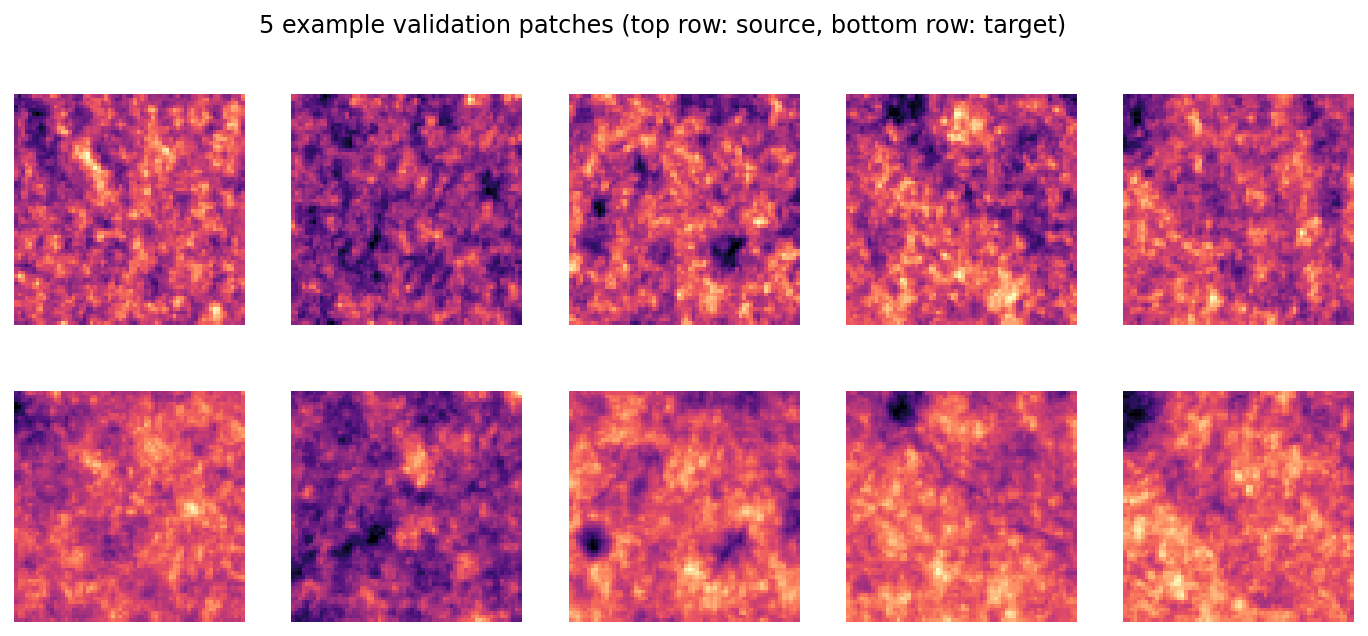

In [8]:
plt.figure(figsize=(12,5))
plot_some(X_val[:5],Y_val[:5])
plt.suptitle('5 example validation patches (top row: source, bottom row: target)');

<hr style="height:2px;">

# CARE model

Before we construct the actual CARE model, we have to define its configuration via a `Config` object, which includes 
* parameters of the underlying neural network,
* the learning rate,
* the number of parameter updates per epoch,
* the loss function, and
* whether the model is probabilistic or not.

The defaults should be sensible in many cases, so a change should only be necessary if the training process fails.  

---

<span style="color:red;font-weight:bold;">Important</span>: Note that for this notebook we use a very small number of update steps per epoch for immediate feedback, whereas this number should be increased considerably (e.g. `train_steps_per_epoch=400`) to obtain a well-trained model.

In [9]:
config = Config(axes, n_channel_in, n_channel_out, train_steps_per_epoch=10)
print(config)
vars(config)

Config(axes='ZYXC', n_channel_in=1, n_channel_out=1, n_dim=3, probabilistic=False, train_batch_size=16, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_epochs=100, train_learning_rate=0.0004, train_loss='mae', train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_steps_per_epoch=10, train_tensorboard=True, unet_input_shape=(None, None, None, 1), unet_kern_size=3, unet_last_activation='linear', unet_n_depth=2, unet_n_first=32, unet_residual=True)


{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mae',
 'train_epochs': 100,
 'train_steps_per_epoch': 10,
 'train_learning_rate': 0.0004,
 'train_batch_size': 16,
 'train_tensorboard': True,
 'train_reduce_lr': {'factor': 0.5, 'patience': 10, 'min_delta': 0}}

We now create a CARE model with the chosen configuration:

In [10]:
model = CARE(config, 'my_model', basedir='models')

2021-07-16 17:16:56.438885: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-16 17:16:56.439051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-07-16 17:16:56.439060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      


<hr style="height:2px;">

# Training

Training the model will likely take some time. We recommend to monitor the progress with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard) (example below), which allows you to inspect the losses during training.
Furthermore, you can look at the predictions for some of the validation images, which can be helpful to recognize problems early on.

You can start TensorBoard from the current working directory with `tensorboard --logdir=.`
Then connect to [http://localhost:6006/](http://localhost:6006/) with your browser.

![](http://csbdeep.bioimagecomputing.com/img/tensorboard_denoising3D.png)

In [11]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

 decorate the function with @tf.autograph.experimental.do_not_convert
2021-07-16 17:20:13.342333: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-16 17:20:13.366389: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3399905000 Hz
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7fc665387790>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda on a single line and with unique argument names.
Match 0:
(lambda x: K.mean(x, axis=(- 1)))

Match 1:
(lambda x: x)

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function _mean_or_not.<locals>.<lambda> at 0x7fc665387790>: found multiple definitions with identical signatures at the location. This error may be avoided by defining each lambda o

Plot final training history (available in TensorBoard during training):

['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


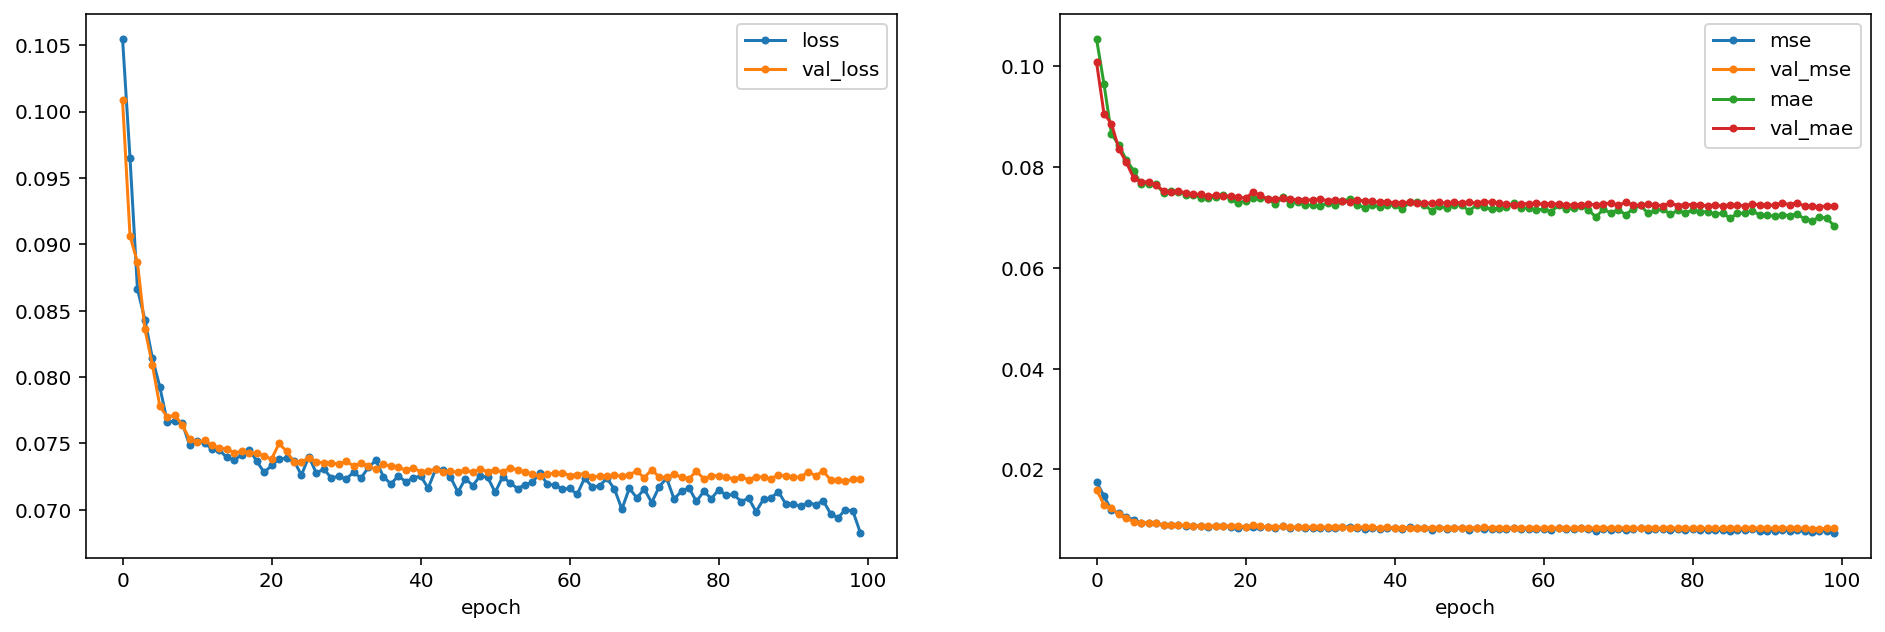

In [12]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'],['mse','val_mse','mae','val_mae']);

<hr style="height:2px;">

# Evaluation

Example results for validation images.

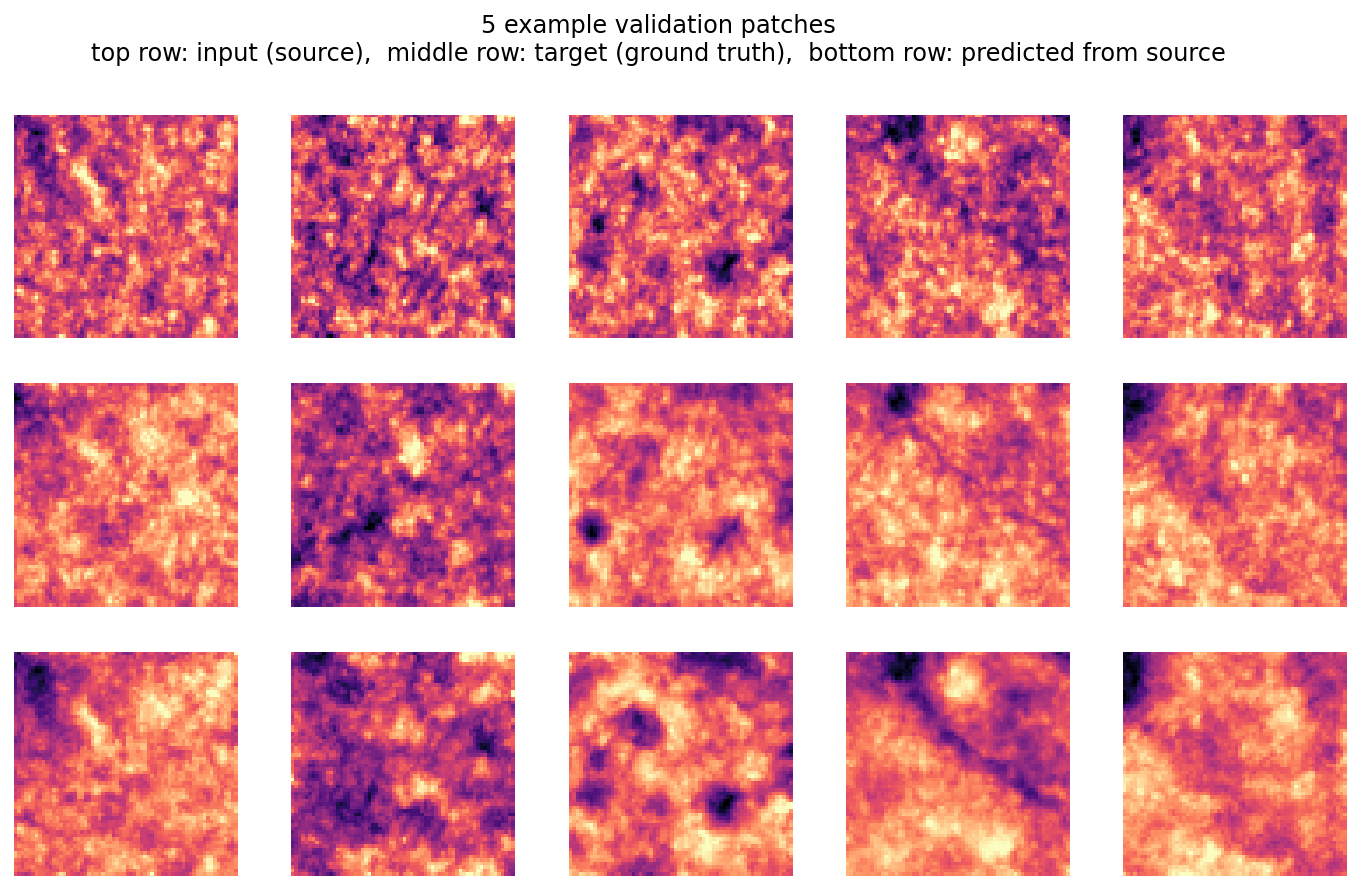

In [13]:
plt.figure(figsize=(12,7))
_P = model.keras_model.predict(X_val[:5])
if config.probabilistic:
    _P = _P[...,:(_P.shape[-1]//2)]
plot_some(X_val[:5],Y_val[:5],_P,pmax=99.5)
plt.suptitle('5 example validation patches\n'      
             'top row: input (source),  '          
             'middle row: target (ground truth),  '
             'bottom row: predicted from source');

<hr style="height:2px;">

# Export model to be used with CSBDeep **Fiji** plugins and **KNIME** workflows

See https://github.com/CSBDeep/CSBDeep_website/wiki/Your-Model-in-Fiji for details.

In [14]:
model.export_TF()

2021-07-16 23:09:25.443474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-07-16 23:09:25.443504: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/tmptu3dpmgs/model/saved_model.pb

Model exported in TensorFlow's SavedModel format:
/home/jrho/Repos/CSBDeep/jrho/denoising3D/models/my_model/TF_SavedModel.zip
